In [21]:
%matplotlib inline

In [22]:
import numpy as np
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Initialize functions

###a. Simulation - resampling

In [23]:
def sim_CCC_SG(mouse_ID, clone_distribution_SG, clone_distribution_IST, colors_SG, colors_IST, iterations):
    
    """

    Bootstrapping function to randomly resample empirical data in order to simulate the distribution of correlated, 
    non-correlated and unlabelled clones in each mouse under the assumption that SG and IST are independent.

    ----------
    mouse_ID: [list] of mice / experiments from which the empirical data used for the simulation is derived.
    
    clone_distribution_IST: [DataFrame] containing istmus clone distribution for each mouse. Indices must be mouse IDs, 
    columns must be clones per HF.
    
    colors_SG: [DataFrame] containing SG color distribution for each mouse. Indices must be mouse IDs, 
    columns must be number of SG clones which are 'B', 'G', 'Y', 'R'.
    
    colors_IST: [DataFrame] containing IST color distribution for each mouse. Indices must be mouse IDs, 
    columns must be number of IST clones which are 'B', 'G', 'Y', 'R'.
    
    ----------
    
    returns [DataFrame] containing the fraction of correlated, non-correlated and non labelled clones over 
    each iteration in each mouse
    
    """
    
    #initialize output file
    
    ix1, ix2 = [], []
    
    for it in range(iterations):
        ix1 += [it] * 3
        ix2 += ['no_label','non_corr','corr']
    
    output = pd.DataFrame(index = [ix1, ix2], columns = mouse_ID)
    
    #initialize SG clone distributions for np.random.choice
    
    clones_choice_SG = {}
    
    for mouse in clone_distribution_SG.index:
        tmp = []
        
        for clones_per_SG in clone_distribution_SG.columns:
            tmp += [clones_per_SG] * clone_distribution_SG.ix[mouse, clones_per_SG]
            
        clones_choice_SG[mouse] = tmp
    
    #initialize IST clone distributions for np.random.choice
    
    clones_choice_IST = {}
    
    for mouse in clone_distribution_IST.index:
        tmp = []
        
        for clones_per_IST in clone_distribution_IST.columns:
            tmp += [clones_per_IST] * clone_distribution_IST.ix[mouse, clones_per_IST]
            
        clones_choice_IST[mouse] = tmp
        
    #initialize SG color distribution for np.random.choice
    
    colors_choice_SG = {}
    
    for mouse in colors_SG.index:
        tmp = []
        
        for color in colors_SG.columns:
            tmp += [color] * colors_SG.ix[mouse, color]
            
        colors_choice_SG[mouse] = tmp
        
    #initialize IST color distribution for np.random.choice
    
    colors_choice_IST = {}
    
    for mouse in colors_IST.index:
        tmp = []
        
        for color in colors_IST.columns:
            tmp += [color] * colors_IST.ix[mouse, color]
            
        colors_choice_IST[mouse] = tmp
        
    #iterate over simulation repeats
    
    for it in range(iterations):
        
        #iterate over mice
        
        for mouse in mouse_ID:
            
            #initialize count
            
            no_label_tmp = 0
            non_corr_tmp = 0
            corr_tmp = 0
            
            #iterate of number of HFs that were counted per mouse (can be derived from e.g. SG clone distribution)
            
            for HF in range(len(clones_choice_SG[mouse])):
                
                #chose number of SG clones and their colors
                
                c_SG = np.random.choice(colors_choice_SG[mouse], np.random.choice(clones_choice_SG[mouse], 1))
                
                #chose number of IST clones and their colors
                
                c_IST = np.random.choice(colors_choice_IST[mouse], np.random.choice(clones_choice_IST[mouse], 1))
                
                #score
                                        
                for c_SG_tmp in set(c_SG):
                    
                    if len(c_IST) == 0:
                        no_label_tmp += 1
                        
                    elif c_SG_tmp not in c_IST:
                        non_corr_tmp += 1
                            
                    elif c_SG_tmp in c_IST:
                        corr_tmp += 1
                    
            #update output
            
            output.ix[it, 'no_label'][mouse] = float(no_label_tmp) / float(no_label_tmp + non_corr_tmp + corr_tmp)
            output.ix[it, 'non_corr'][mouse] = float(non_corr_tmp) / float(no_label_tmp + non_corr_tmp + corr_tmp)
            output.ix[it, 'corr'][mouse] = float(corr_tmp) / float(no_label_tmp + non_corr_tmp + corr_tmp)
            
    return output

###b. Drawing

In [24]:
def draw_sim_CCC(sim_results, emp_results = None):
    
    """
    
    Draws resampling results as violin plots and superimposes empirical results
    
    ----------
    
    sim_results: [DataFrame] containing the fraction of correlated, non-correlated and non labelled clones over 
    each iteration in each mouse
    
    emp_results; [DataFrame] containing the empirically determined fractions of correlated, non-correlated and 
    non labelled clones in each mouse.
    
    """
    
    #create figure
    
    fig = plt.figure(facecolor = 'w', figsize = (20,10))
    ax = plt.axes()
    
    #create xaxis
    
    ax.set_xlim(0, len(sim_results.columns))
    
    xticks = []
    
    for ix in range(len(sim_results.columns)):
        xticks += [ix + 0.25, ix + 0.5, ix + 0.75]
        
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    
    #create yaxis
    
    ax.set_ylim(0,1)
    
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], family = 'Arial', fontsize = 30)
    
    ax.set_ylabel('Probability', family = 'Arial', fontsize = 35)
    
    #create position and colormap
    
    posmap = {'no_label':0.25,
               'non_corr':0.5,
               'corr':0.75}
    
    cmap = {'no_label':'blue',
             'non_corr':'green',
             'corr':'red'}
    
    #plot data
    
    for pos, mouse in enumerate(sim_results.columns):
        
        #draw text
        
        ax.text(pos + 0.5, -0.05, mouse, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
                
        for x in ['no_label','non_corr','corr']:
            
            #draw violin plots
            
            violin = ax.violinplot([val for val in sim_results.swaplevel(0,1).ix[x][mouse].values],
                                   positions = [pos + posmap[x]],
                                   showextrema = False, widths = 0.25)
            
            for v in violin['bodies']:
        
                v.set_edgecolor(cmap[x])
                v.set_facecolor(cmap[x])
                v.set_linewidth(1.0)
                v.set_alpha(0.25)
                
            #draw empirical data
            
            try:
                ax.scatter(pos + posmap[x],
                           [emp_results.ix[mouse, x]], 
                           color = cmap[x],
                           edgecolor = cmap[x], 
                           s=100)
            except:
                continue

In [25]:
def draw_sim_CCC(sim_results, emp_results = None):
    
    #create figure
    
    fig = plt.figure(facecolor = 'w', figsize = (20,10))
    ax = plt.axes()
    
    #create xaxis
    
    ax.set_xlim(0, len(sim_results.columns))
    
    xticks = []
    
    for ix in range(len(sim_results.columns)):
        xticks += [ix + 0.25, ix + 0.5, ix + 0.75]
        
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    
    #create yaxis
    
    ax.set_ylim(0,1)
    
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], family = 'Arial', fontsize = 30)
    
    ax.set_ylabel('Probability', family = 'Arial', fontsize = 35)
    
    #create position and colormap
    
    posmap = {'no_label':0.25,
               'non_corr':0.5,
               'corr':0.75}
    
    cmap = {'no_label':'blue',
             'non_corr':'green',
             'corr':'red'}
    
    #plot data
    
    for pos, mouse in enumerate(sim_results.columns):
        
        #draw text
        
        ax.text(pos + 0.5, -0.05, mouse, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
                
        for x in ['no_label','non_corr','corr']:
            
            #draw violin plots
            
            if np.sum([val for val in sim_results.swaplevel(0,1).ix[x][mouse].values]) == 0:
                continue
                
            else:
                
                q_5 = np.percentile(sim_results.swaplevel(0,1).ix[x][mouse].values, 5)
                q_95 = np.percentile(sim_results.swaplevel(0,1).ix[x][mouse].values, 95)
                violin_tmp = [val for val in sim_results.swaplevel(0,1).ix[x][mouse].values if val >= q_5 and val <= q_95]
                
                violin = ax.violinplot(violin_tmp,
                                       positions = [pos + posmap[x]],
                                       showextrema = False, widths = 0.25)

                for v in violin['bodies']:

                    v.set_edgecolor(cmap[x])
                    v.set_facecolor(cmap[x])
                    v.set_linewidth(1.0)
                    v.set_alpha(0.25)
                    
                ax.plot([pos + posmap[x] - 0.05, pos + posmap[x] + 0.05],[q_5, q_5], color = cmap[x], linewidth = 3)
                ax.plot([pos + posmap[x] - 0.05, pos + posmap[x] + 0.05],[q_95, q_95], color = cmap[x], linewidth = 3)

            #draw empirical data
            
            try:
                ax.scatter(pos + posmap[x],
                           [emp_results.ix[mouse, x]], 
                           color = cmap[x],
                           edgecolor = cmap[x], 
                           s=100)
            except:
                continue

#2. Load data

In [26]:
mouse_ID = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7']

In [27]:
clones_per_IST_emp = pd.DataFrame(index = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7'], columns = range(5))

clones_per_IST_emp.ix['AS51:1'] = [16,6,10,0,0]
clones_per_IST_emp.ix['AS51:2'] = [2,2,1,0,0]
clones_per_IST_emp.ix['AS48:1'] = [21,13,0,0,0]
clones_per_IST_emp.ix['AS90:7'] = [9,11,1,0,0]
clones_per_IST_emp.ix['AS42:2'] = [11,9,2,0,0]
clones_per_IST_emp.ix['AS42:1'] = [3,10,0,0,0]
clones_per_IST_emp.ix['AS90:4'] = [5,5,3,1,0]
clones_per_IST_emp.ix['AS122:3'] = [3,5,7,1,0]
clones_per_IST_emp.ix['AS152:7'] = [3,8,5,6,0]

In [28]:
clones_per_SG_emp = pd.DataFrame(index = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7'], columns = range(5))

clones_per_SG_emp.ix['AS51:1'] = [0,29,4,0,0]
clones_per_SG_emp.ix['AS51:2'] = [0,6,0,0,0]
clones_per_SG_emp.ix['AS48:1'] = [0,32,2,0,0]
clones_per_SG_emp.ix['AS90:7'] = [0,20,2,0,0]
clones_per_SG_emp.ix['AS42:2'] = [0,18,3,0,0]
clones_per_SG_emp.ix['AS42:1'] = [0,12,1,0,0]
clones_per_SG_emp.ix['AS90:4'] = [0,9,5,0,0]
clones_per_SG_emp.ix['AS122:3'] = [0,14,1,1,0]
clones_per_SG_emp.ix['AS152:7'] = [0,18,3,0,0]

In [29]:
colors_per_mouse_SG_emp = pd.DataFrame(index = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7'], 
                                       columns = ['B','G','Y','R'])

colors_per_mouse_SG_emp.ix['AS51:1'] = [0,5,11,21]
colors_per_mouse_SG_emp.ix['AS51:2'] = [0,0,2,4]
colors_per_mouse_SG_emp.ix['AS48:1'] = [0,25,10,1]
colors_per_mouse_SG_emp.ix['AS90:7'] = [1,0,15,8]
colors_per_mouse_SG_emp.ix['AS42:2'] = [0,1,12,11]
colors_per_mouse_SG_emp.ix['AS42:1'] = [0,0,10,4]
colors_per_mouse_SG_emp.ix['AS90:4'] = [0,0,9,11]
colors_per_mouse_SG_emp.ix['AS122:3'] = [2,7,2,8]
colors_per_mouse_SG_emp.ix['AS152:7'] = [1,10,4,9]

In [30]:
colors_per_mouse_IST_emp = pd.DataFrame(index = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7'], 
                                       columns = ['B','G','Y','R'])

colors_per_mouse_IST_emp.ix['AS51:1'] = [0,2,11,13]
colors_per_mouse_IST_emp.ix['AS51:2'] = [0,0,3,3]
colors_per_mouse_IST_emp.ix['AS48:1'] = [0,10,2,0]
colors_per_mouse_IST_emp.ix['AS90:7'] = [5,0,5,3]
colors_per_mouse_IST_emp.ix['AS42:2'] = [0,0,6,8]
colors_per_mouse_IST_emp.ix['AS42:1'] = [0,0,5,4]
colors_per_mouse_IST_emp.ix['AS90:4'] = [3,0,7,5]
colors_per_mouse_IST_emp.ix['AS122:3'] = [3,7,8,4]
colors_per_mouse_IST_emp.ix['AS152:7'] = [2,14,10,9]

In [31]:
iterations = 1000

In [32]:
emp_results = pd.DataFrame(index = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7'],
                           columns = ['corr','non_corr','no_label'])

emp_results.ix['AS51:1'] = [0.4054,0.05410,0.5405]
emp_results.ix['AS51:2'] = [0.3333,0.1667,0.5000]
emp_results.ix['AS48:1'] = [0.353,0.029,0.618]
emp_results.ix['AS90:7'] = [0.2083333333,0.375,0.4166666667]
emp_results.ix['AS42:2'] = [0.3333,0.2083,0.4583]
emp_results.ix['AS42:1'] = [0.4285714286,0.2142857143,0.3571428571]
emp_results.ix['AS90:4'] = [0.55,0.10,0.35]
emp_results.ix['AS122:3'] = [0.3684,0.4737,0.1579]
emp_results.ix['AS152:7'] = [0.3333333333,0.5833333333,0.08333333333]

#3. Simulate and draw

In [33]:
sim_results = sim_CCC_SG(mouse_ID,
                         clones_per_SG_emp,
                         clones_per_IST_emp, 
                         colors_per_mouse_SG_emp, 
                         colors_per_mouse_IST_emp, 
                         iterations)

In [34]:
mice_sel = ['AS51:1','AS48:1','AS90:7','AS42:2','AS152:7','AS90:4']

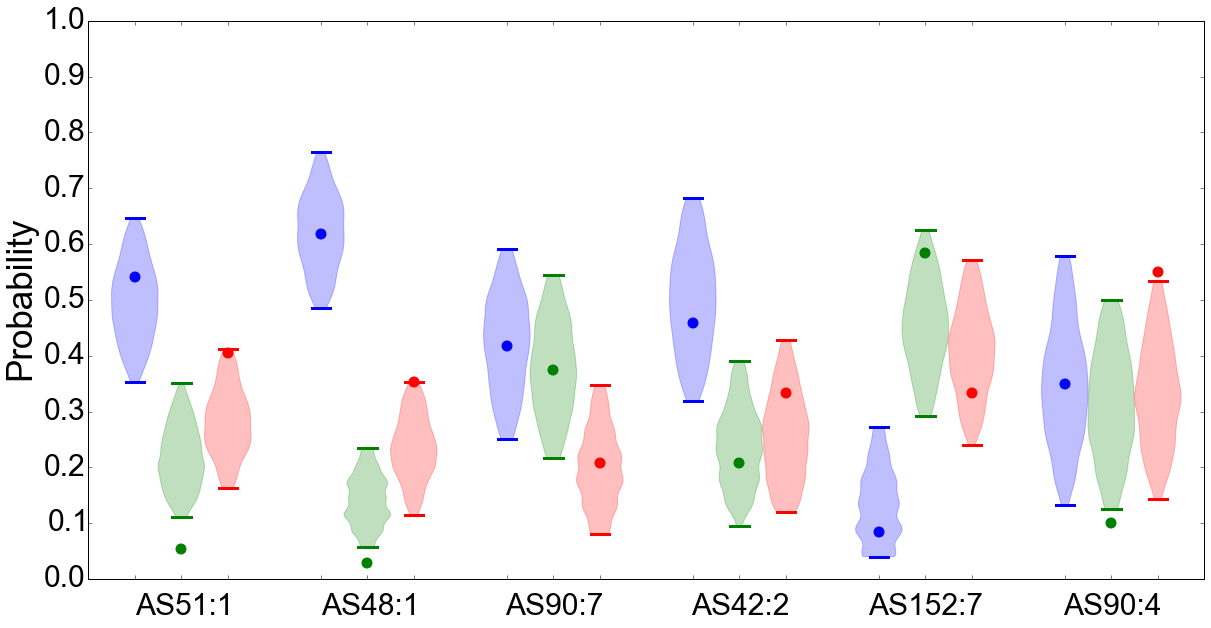

In [35]:
draw_sim_CCC(sim_results[mice_sel], emp_results = emp_results)

#5. P-values (probability that a correlation probability equal to or more extreme than the empirically observed is reached if the null hypothesis [no correlation] is true)

In [36]:
def get_pvalue_corr(sim_results, emp_results):
    
    #create output
    
    output = pd.Series(index = sim_results.columns)
    
    #iterate over mice
    
    for mouse in sim_results.columns:
        
        null_distr_tmp = sim_results.swaplevel(0,1).ix['corr'][mouse]
        
        emp_tmp = emp_results.ix[mouse, 'corr']
        
        p_tmp = float(np.sum(null_distr_tmp > emp_tmp)) / len(null_distr_tmp)
        
        output[mouse] = p_tmp
        
    return output

In [38]:
print get_pvalue_corr(sim_results[mice_sel], emp_results)

AS51:1     0.064
AS48:1     0.041
AS90:7     0.487
AS42:2     0.231
AS152:7    0.788
AS90:4     0.038
dtype: float64
